<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Dementia_prediction_SVM_Classifier_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Prediction of Dementia using an SVM model on brain MRI features

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data exploration, preprocessing and visualization
* implement SVM Classifier on the data
* explore various parameters of SVM classifier and implement OneVsOne classifier
* calculate the metrics and plot the roc_curve

## Information

**About Dementia**

Dementia is a general term for loss of memory and other mental abilities severe enough to interfere with daily life. It is caused by physical changes in the brain. Alzheimer's is the most common type of dementia, but there are many kinds.

**Brain Imaging via magnetic resonance imaging (MRI) and Machine Learning**

* MRI is used for the evaluation of patients with suspected Alzheimer's disease
* MRIs detect both, local and generalized shrinkage of brain tissue.
* MRI features predict the rate of decline of AD and may guide therapy in the future
* Using machine learning on MRI features could help in automatedly and accurately predicting the progress of a patient from mild cognitive impairment to dementia

To understand the basics of MRI technique, you could refer [here](https://case.edu/med/neurology/NR/MRI%20Basics.htm)

## Dataset

The dataset chosen for this mini-project is [OASIS - Longitudinal brain MRI Dataset](https://www.oasis-brains.org/). This dataset consists of a longitudinal MRI collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

**Dataset fields:**

* Subject ID - Subject Identification
* MRI ID - MRI Exam Identification
* Group - Target variable with 3 labels ('NonDemented', 'Demented', 'Converted')
* Visit - Visit order
* MR Delay - MR Delay Time (Contrast)
* M/F - Male or Female
* Hand - Unique value 'R'
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)
* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD)
* Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). A computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

For learning more on building a machine learning model to predict dementia using SVM, refer [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7408873/).

In [1]:
#@title Download the dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv
print("Data downloaded successfully!")

Data downloaded successfully!


### Import required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

### Load the dataset

In [3]:
# YOUR CODE HERE
df = pd.read_csv('https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv')

In [4]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [6]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


### Pre-processing and Data Engineering

#### Remove unwanted columns

In [7]:
# YOUR CODE HERE
df_clean = df.drop(['MRI ID', 'Hand'], axis = 1)

#### Encode categorical features into numeric

In [8]:
# YOUR CODE HERE
df_clean['M/F'] = df_clean['M/F'].replace(['M','F'], [1,0])

In [9]:
df_clean['Group'].unique()

array(['Nondemented', 'Demented', 'Converted'], dtype=object)

In [10]:
#df_clean['Group'] = df_clean['Group'].replace(['Converted'], ['Demented'])
df_clean['Group'] = df_clean['Group'].replace(['Converted', 'Demented', 'Nondemented'], [2,1,0])
df_clean.describe()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,0.589812,1.882038,595.104558,0.428954,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.664461,0.922843,635.485118,0.495592,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,0.000000,1.000000,0.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,0.000000,1.000000,0.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,0.000000,2.000000,552.000000,0.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,1.000000,2.000000,873.000000,1.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,2.000000,5.000000,2639.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


#### Handle the null values by removing or replacing

In [11]:
# YOUR CODE HERE
df_clean = df_clean.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 372
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  354 non-null    object 
 1   Group       354 non-null    int64  
 2   Visit       354 non-null    int64  
 3   MR Delay    354 non-null    int64  
 4   M/F         354 non-null    int64  
 5   Age         354 non-null    int64  
 6   EDUC        354 non-null    int64  
 7   SES         354 non-null    float64
 8   MMSE        354 non-null    float64
 9   CDR         354 non-null    float64
 10  eTIV        354 non-null    int64  
 11  nWBV        354 non-null    float64
 12  ASF         354 non-null    float64
dtypes: float64(5), int64(7), object(1)
memory usage: 38.7+ KB


#### Identify feature and target and split it into train test

In [12]:
%pip install mlxtend

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [16]:
# YOUR CODE HERE
x = df_clean.drop(columns=['Subject ID', 'Group'])
y = df_clean[['Group']]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)

In [18]:
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

#Use SFS to select the top 10 features
sfs.fit(x_train, y_train)
print(sfs)

#Create a dataframe for the SFS results
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
print("Features", df_SFS_results)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(),
                          k_features=(10, 10), scoring='r2')
Features                        feature_idx              cv_scores avg_score  \
1                             (7,)   [0.3181966175223975]  0.318197   
2                           (7, 9)  [0.33263347885820915]  0.332633   
3                        (7, 8, 9)  [0.34744611830022065]  0.347446   
4                     (5, 7, 8, 9)   [0.3576373796129063]  0.357637   
5                  (4, 5, 7, 8, 9)   [0.3740470872520413]  0.374047   
6               (2, 4, 5, 7, 8, 9)  [0.38180809531561033]  0.381808   
7            (2, 4, 5, 6, 7, 8, 9)   [0.3877184910633936]  0.387718   
8         (2, 3, 4, 5, 6, 7, 8, 9)  [0.38878216598449633]  0.388782   
9      (0, 2, 3, 4, 5, 6, 7, 8, 9)  [0.38977432431221104]  0.389774   
10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)  [0.39579281680451284]  0.395793   

                                        feature_names  
1                             

### EDA &  Visualization

#### Plot the distribution of all the variables using a histogram

In [19]:
x.head()

,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,1,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,2,538,0,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,1,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039


<Axes: >

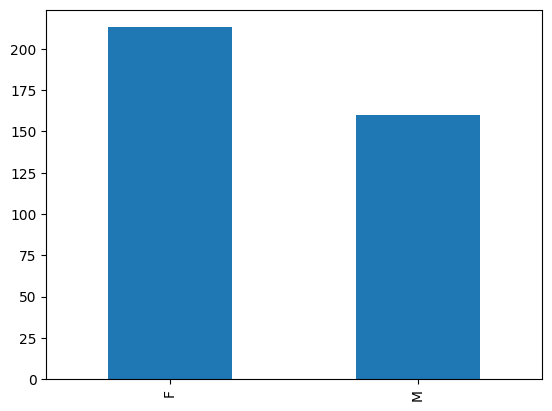

In [20]:
# YOUR CODE HERE
sex = df['M/F'].value_counts()
sex.plot(kind='bar')

<Axes: >

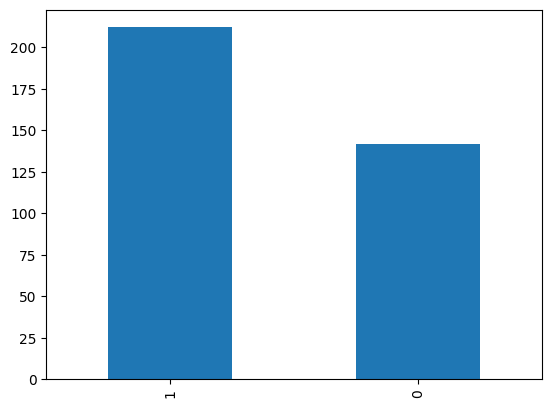

In [21]:
df_temp = pd.DataFrame()
df_temp['MR Delay'] = x['MR Delay']
df_temp[df_temp['MR Delay'] != 0] = 1
MRD = df_temp['MR Delay'].value_counts()
MRD.plot(kind='bar')

#### Visualize the frequency of Age

<Axes: >

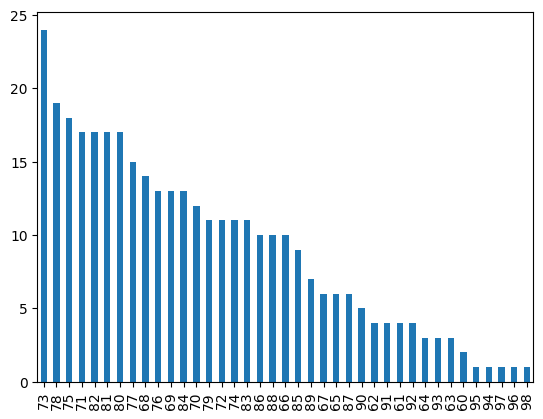

In [22]:
# YOUR CODE HERE
age = x['Age'].value_counts()
age.plot(kind='bar')

#### How many people have Alzheimer? Visualize with an appropriate plot

the same person visits two or more times; extract the single visit data and plot

**Hint**: Visit = 1

<Axes: >

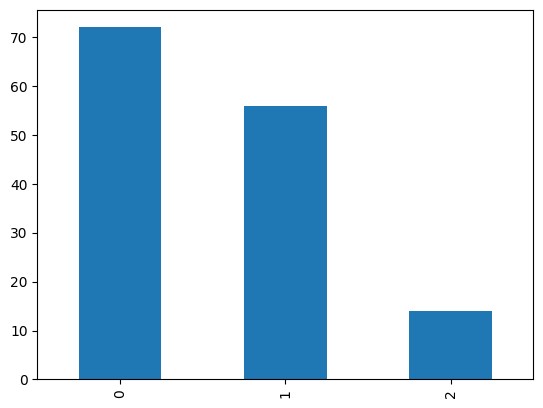

In [23]:
# YOUR CODE HERE
x_1_visit = df_clean[df_clean['Visit'] == 1]
AD = x_1_visit['Group'].value_counts()
AD.plot(kind='bar')

In [24]:
non_demented = df_clean[df_clean['Group'] == 0]
demented = df_clean[df_clean['Group'] == 1]
converted = df_clean[df_clean['Group'] == 2]

In [25]:
non_demented.describe()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,190.0,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,0.0,1.968421,670.242105,0.321053,77.057895,15.142105,2.394737,29.226316,0.005263,1495.500000,0.740900,1.191063
std,0.0,0.980796,672.807019,0.468114,8.096104,2.742149,1.047534,0.882722,0.051163,184.888262,0.037705,0.144029
min,0.0,1.000000,0.000000,0.000000,60.000000,8.000000,1.000000,26.000000,0.000000,1106.000000,0.644000,0.876000
25%,0.0,1.000000,0.000000,0.000000,71.000000,13.000000,2.000000,29.000000,0.000000,1358.250000,0.717250,1.073750
50%,0.0,2.000000,631.000000,0.000000,77.000000,16.000000,2.000000,29.000000,0.000000,1474.500000,0.739000,1.190000
75%,0.0,2.750000,1129.750000,1.000000,82.000000,18.000000,3.000000,30.000000,0.000000,1634.750000,0.769000,1.292500
max,0.0,5.000000,2517.000000,1.000000,97.000000,23.000000,5.000000,30.000000,0.500000,2004.000000,0.837000,1.587000


In [26]:
demented.describe()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,127.0,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,1.0,1.716535,448.629921,0.598425,76.204724,13.826772,2.771654,24.322835,0.673228,1490.700787,0.715181,1.192417
std,0.0,0.775596,513.083177,0.492158,7.349915,3.026587,1.196483,4.657954,0.304581,172.378336,0.033299,0.133422
min,1.0,1.000000,0.000000,0.000000,61.000000,6.000000,1.000000,4.000000,0.500000,1143.000000,0.646000,0.897000
25%,1.0,1.000000,0.000000,0.000000,71.000000,12.000000,2.000000,21.000000,0.500000,1374.000000,0.691000,1.123500
50%,1.0,2.000000,486.000000,1.000000,76.000000,14.000000,3.000000,26.000000,0.500000,1477.000000,0.711000,1.188000
75%,1.0,2.000000,686.500000,1.000000,82.000000,16.000000,4.000000,28.000000,1.000000,1562.000000,0.737000,1.277500
max,1.0,5.000000,2508.000000,1.000000,98.000000,20.000000,5.000000,30.000000,2.000000,1957.000000,0.806000,1.535000


In [27]:
converted.describe()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.00000,37.000000,37.000000,37.000000,37.00000,37.000000
mean,2.0,2.027027,771.810811,0.351351,79.756757,15.459459,1.72973,28.675676,0.256757,1459.270270,0.72373,1.212405
std,0.0,1.040472,767.296366,0.483978,7.425203,2.523166,0.96173,1.564432,0.253356,135.432773,0.03543,0.109295
min,2.0,1.000000,0.000000,0.000000,65.000000,12.000000,1.00000,24.000000,0.000000,1264.000000,0.66600,1.019000
25%,2.0,1.000000,0.000000,0.000000,74.000000,14.000000,1.00000,28.000000,0.000000,1383.000000,0.69600,1.106000
50%,2.0,2.000000,706.000000,0.000000,81.000000,16.000000,1.00000,29.000000,0.500000,1423.000000,0.71800,1.234000
75%,2.0,3.000000,1422.000000,1.000000,86.000000,18.000000,2.00000,30.000000,0.500000,1587.000000,0.75000,1.269000
max,2.0,5.000000,2639.000000,1.000000,92.000000,20.000000,4.00000,30.000000,0.500000,1722.000000,0.79900,1.388000


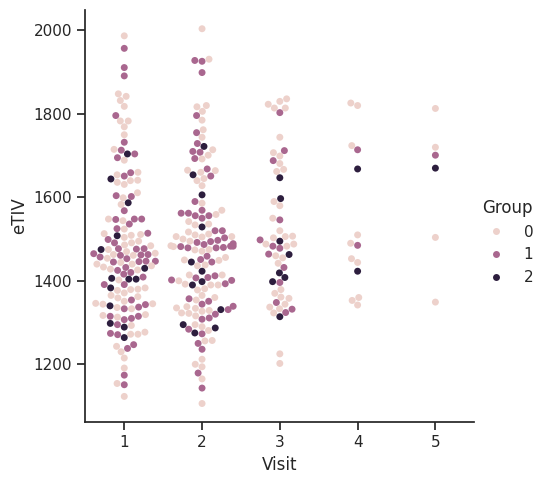

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x="Visit", y="eTIV", hue="Group", kind="swarm", data=df_clean)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 93.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 24.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 19.0% of the points cannot be plac

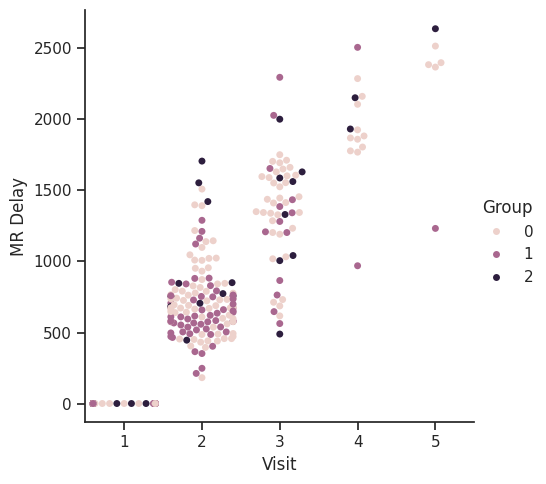

In [29]:
sns.catplot(x="Visit", y="MR Delay", hue="Group", kind="swarm", data=df_clean)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 76.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 73.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 78.1% of the points cannot be plac

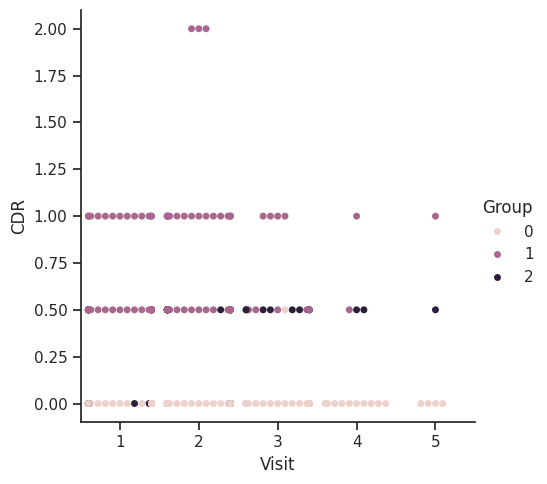

In [30]:
sns.catplot(x="Visit", y="CDR", hue="Group", kind="swarm", data=df_clean)

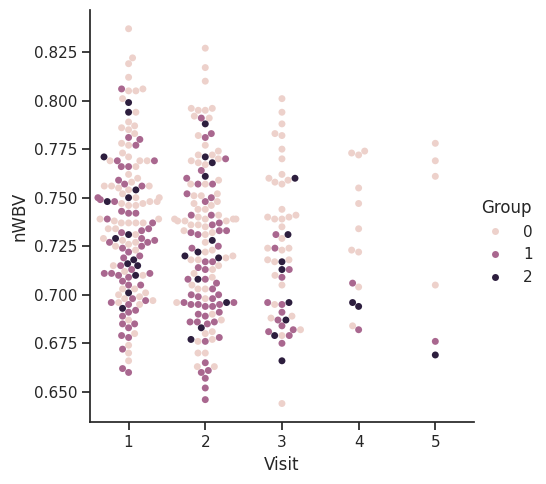

In [31]:
sns.catplot(x="Visit", y="nWBV", hue="Group", kind="swarm", data=df_clean)

#### Calculate the correlation of features and plot the heatmap

In [32]:
# YOUR CODE HERE
corrMatrix = df_clean.corr()
print(corrMatrix)

             Group     Visit  MR Delay       M/F       Age      EDUC  \
Group     1.000000 -0.048616 -0.044427  0.142724  0.051669 -0.080258   
Visit    -0.048616  1.000000  0.922833  0.064174  0.186306  0.013574   
MR Delay -0.044427  0.922833  1.000000  0.045183  0.204313  0.044399   
M/F       0.142724  0.064174  0.045183  1.000000 -0.027910  0.089937   
Age       0.051669  0.186306  0.204313 -0.027910  1.000000 -0.024977   
EDUC     -0.080258  0.013574  0.044399  0.089937 -0.024977  1.000000   
SES      -0.053845 -0.051622 -0.030813 -0.045776 -0.046857 -0.722647   
MMSE     -0.337200 -0.029031  0.073640 -0.159501  0.055880  0.184459   
CDR       0.566156 -0.015544 -0.066391  0.205822 -0.022759 -0.129440   
eTIV     -0.052125  0.128745  0.119383  0.571443  0.040182  0.267933   
nWBV     -0.257441 -0.123453 -0.102139 -0.241709 -0.526316 -0.019822   
ASF       0.036967 -0.133897 -0.125088 -0.560791 -0.031783 -0.251677   

               SES      MMSE       CDR      eTIV      nWBV     

<ipython-input-32-6b66b97f8c5e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df_clean.corr()


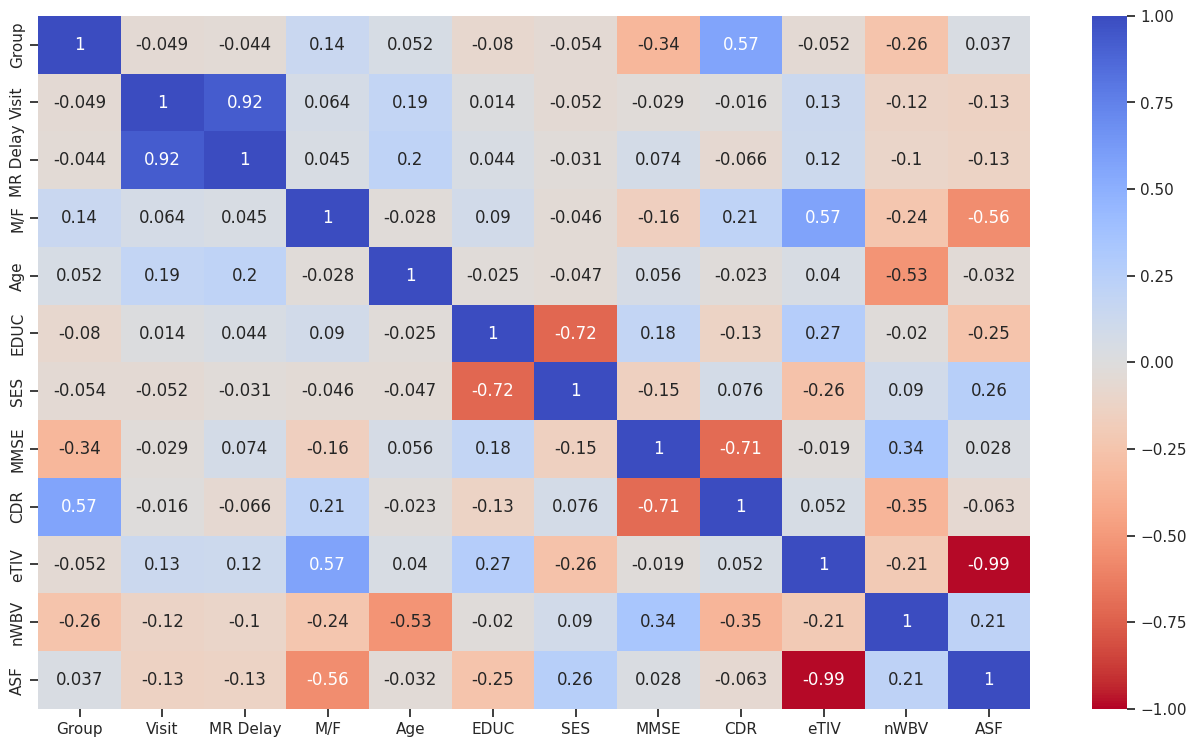

In [33]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm_r')

### Model training and evaluation

**Hint:** SVM model from sklearn

In [34]:
# YOUR CODE HERE
classifier = SVC(kernel='linear', random_state = 100)
classifier.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', random_state=100)

In [35]:
y_pred = classifier.predict(x_test)
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

#### Support vectors of the model

* Find the samples of the dataset which are the support vectors of the model

In [36]:
# YOUR CODE HERE
print(classifier.support_vectors_[:5, :])

[[1.000e+00 0.000e+00 1.000e+00 7.400e+01 1.800e+01 2.000e+00 2.900e+01
  0.000e+00 1.463e+03 7.370e-01 1.199e+00]
 [3.000e+00 1.651e+03 1.000e+00 7.200e+01 1.800e+01 1.000e+00 3.000e+01
  0.000e+00 1.681e+03 7.290e-01 1.044e+00]
 [2.000e+00 6.720e+02 1.000e+00 8.200e+01 1.700e+01 1.000e+00 2.900e+01
  0.000e+00 1.692e+03 7.230e-01 1.037e+00]
 [2.000e+00 8.730e+02 1.000e+00 7.000e+01 1.800e+01 1.000e+00 3.000e+01
  0.000e+00 1.660e+03 7.380e-01 1.057e+00]
 [2.000e+00 4.540e+02 1.000e+00 7.900e+01 1.600e+01 1.000e+00 3.000e+01
  0.000e+00 1.817e+03 7.360e-01 9.660e-01]]


In [37]:
print(classifier.support_vectors_.shape)

(87, 11)


#### Confusion matrix for multi-class classification

* Predict the test and plot the confusion matrix

In [42]:
y_test.shape

(107, 1)

In [38]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

array([[57,  1,  1],
       [ 0, 36,  1],
       [ 5,  3,  3]])

In [40]:
cm.shape

(3, 3)

<Axes: >

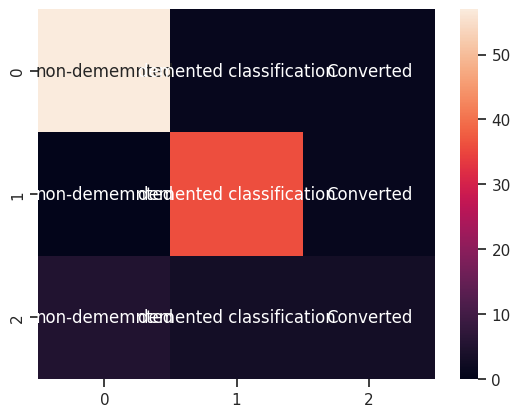

In [44]:
#'Nondemented', 'Demented', 'Converted'
#labels = ['True non-dememnted 57','False demented classification 1','False not demented 5','True demented 43']
labels = ['non-dememnted','demented classification','Converted', 'non-dememnted','demented classification','Converted', 'non-dememnted','demented classification','Converted']
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt='')

#### One VS Rest Classifier

OneVsRestClassifier can also be used for multilabel classification. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed)

* Fit `OneVsRestClassifier` on the data and find the accuracy

Hint: [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [45]:
# YOUR CODE HERE
clf = OneVsRestClassifier(SVC(kernel='linear')).fit(x_train, y_train)
y_pred_OvR = clf.predict(x_test)
y_pred_OvR

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

#### One VS One Classifier

This strategy consists of fitting one classifier per class pair. At prediction time, the class which received the most votes is selected.

* Fit `OneVsOneClassifier` on the data and find the accuracy

Hint: [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

In [46]:
clf = OneVsOneClassifier(SVC(kernel='linear')).fit(x_train, y_train)
y_pred_OvO = clf.predict(x_test)
y_pred_OvO

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

#### Make it binary classification

As stated in the dataset description, 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit. Change `Converted` label into `Demented`.

**Note:** In two-class classification, encode the labels into numerical to plot the roc_curve with predictions.

In [ ]:
# YOUR CODE HERE

#### Compare the performance and predictions of both multi-class and binary classifications

In [ ]:
# YOUR CODE HERE

### Classification report and metrics

#### Confusion matrix

Describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
# YOUR CODE HERE

#### Plot the ROC Curve

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

In [ ]:
# YOUR CODE HERE

### Choice of C for SVM

experiment with different C values given and plot the ROC curve for each

In [ ]:
c_val = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# YOUR CODE HERE

### Report Analysis

* Compare the performance of the model with various Kernel parameters.
* Discuss the impact of parameter C and gamma on performance.
* Comment on the computational cost of implementing one vs one and one vs all to solve multi-class classification with binary classifier.
* When do you call a sample/record in the data as a support vector?